In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
df = pd.read_csv("../lego.population.csv", sep = ",", encoding = "latin1")
#df

## Rensking av datasett

In [3]:
# beholder kun forklaringsvariabler vi trenger
df2 = df[['Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Minifigures', 'Unique_Pieces', 'Ages']]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2['Theme'] = df2['Theme'].astype(str).str.replace(r'[^a-zA-Z0-9\s-]', '', regex = True)

# Gjør om price til float
df2['Price'] = df2['Price'].str.replace('\$', '', regex = True).astype(float)

df2 = df2[~df2['Set_Name'].str.contains("Calendar")]
#df2 = df2[df2['Theme'] != "DUPLO"]

# remove all DUPLO sets
df2 = df2[~df2['Ages'].str.contains('Ages_2')]  
df2 = df2[~df2['Ages'].str.contains('Ages_1½')]

df2

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages
13,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,1.0,52.0,Ages_6+
16,Woody & RC,Disney,69.0,9.99,28.0,1.0,36.0,Ages_4+
17,Mia's Summer Heart Box,Friends,85.0,7.99,36.0,1.0,41.0,Ages_6+
18,Olivia's Summer Heart Box,Friends,93.0,7.99,40.0,2.0,48.0,Ages_6+
19,Police Patrol Car,City,92.0,9.99,36.0,1.0,52.0,Ages_5+
...,...,...,...,...,...,...,...,...
1171,1989 Batmobile,Batman,3306.0,249.99,404.0,3.0,484.0,Ages_16+
1172,Tree House,Ideas,3036.0,199.99,428.0,4.0,482.0,Ages_16+
1173,Welcome to Apocalypseburg!,THE LEGO MOVIE 2,3178.0,299.99,452.0,13.0,692.0,Ages_16+
1174,Jurassic Park: T. rex Rampage,Jurassic World,3120.0,249.99,464.0,6.0,525.0,Ages_16+


## Deler in i subsets med varmerke

In [4]:

trademarked = {
    'Spider-Man',
    'Powerpuff Girls',
    'Minions',
    'Stranger Things',
    'Star Wars',
    'Marvel',
    'Disney',
    'Harry Potter',
    'Minecraft',
    'Jurassic World',
    'Batman',
    'DC',
    'Trolls World Tour',
    'Overwatch',
    'LEGO Frozen 2'
}

uncertain = {
    'Unikitty',
    'Minifigures',
    'THE LEGO MOVIE 2',
    'Speed Champions',
    'Juniors',
    'Creator Expert'
}

notrademark = {
    'Monkie Kid',
    'Friends',
    'City',
    'NINJAGO',
    'DUPLO',
    'Creator 3-in-1',
    'Hidden Side',
    'Ideas',
    'Classic',
    'Powered UP'
}

# verify that the groups are correct
#assert (trademarked | uncertain | notrademark) == set(df2['Theme'])

df_trademark   = df2[df2['Theme'].isin(trademarked)]
df_uncertain   = df2[df2['Theme'].isin(uncertain)]
df_notrademark = df2[df2['Theme'].isin(notrademark)]

print(f"Length trademark:    {len(df_trademark)}")
print(f"Length uncertain:    {len(df_uncertain)}")
print(f"Length no trademark: {len(df_notrademark)}")




Length trademark:    268
Length uncertain:    72
Length no trademark: 324


## 4.A) Pris beskrevet av antall brikker

In [5]:
# enkel lineær regresjon
formel = 'Price ~ Pieces'

model4a = smf.ols(formel, data = df2)
resultat = model4a.fit()

resultat.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     4201.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          7.46e-289
Time:                        19:41:12   Log-Likelihood:                -2939.8
No. Observations:                 664   AIC:                             5884.
Df Residuals:                     662   BIC:                             5893.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0697      0.991      8.140      0.000       6.123      10.016
Pieces         0.0889      0.001     64.812      0.000       0.086       0.092
==============================================================================
Omnibus:                      624.104   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79636.259
Skew:                           3.678   Prob(JB):                         0.00
Kurtosis:                      56.144   Cond. No.                         910.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

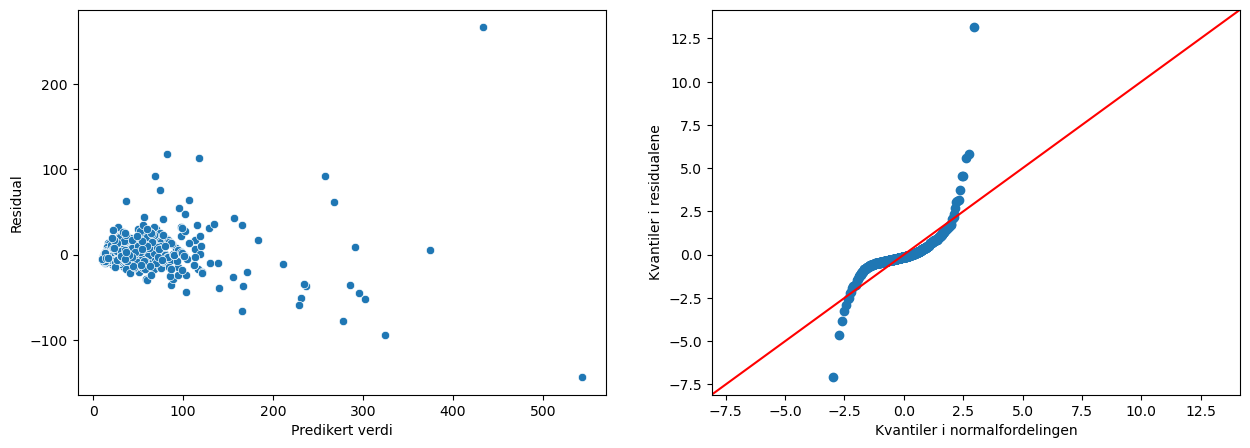

In [6]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = resultat.fittedvalues, y = resultat.resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

sm.qqplot(resultat.resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

## 4.B) Pris beskrivet i antall brikker og forklaringsvariabel

### 4.B.1) Pris beskrevet i antall brikker og antall sider

In [7]:

# multippel lineær regresjon
# TODO: er kanskje meningen å bruke sample data som `data`, ikke df2
model4b1 = smf.ols('Price ~ Pieces + Pages' , data = df2)
result = model4b1.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     2237.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          5.31e-295
Time:                        19:41:12   Log-Likelihood:                -2921.2
No. Observations:                 664   AIC:                             5848.
Df Residuals:                     661   BIC:                             5862.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9402      1.273      2.310      0.021       0.441       5.439
Pieces         0.0774      0.002     33.632      0.000       0.073       0.082
Pages          0.0932      0.015      6.178      0.000       0.064       0.123
==============================================================================
Omnibus:                      744.039   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148514.639
Skew:                           4.864   Prob(JB):                         0.00
Kurtosis:                      75.618   Cond. No.                     1.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.B.2) Pris beskrevet i antall brikker og minifigures 

In [8]:

# multippel lineær regresjon
#'Set_Name', 'Theme', 'Pieces', 'Price', 'Pages', 'Minifigures', 'Unique_Pieces'
model4b2 = smf.ols('Price ~ Pages' , data = df2)

result = model4b2.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     1235.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          1.73e-153
Time:                        19:41:12   Log-Likelihood:                -3252.3
No. Observations:                 664   AIC:                             6509.
Df Residuals:                     662   BIC:                             6518.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.3538      2.020     -4.136      0.000     -12.320      -4.388
Pages          0.5065      0.014     35.144      0.000       0.478       0.535
==============================================================================
Omnibus:                      791.181   Durbin-Watson:                   1.403
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           164891.516
Skew:                           5.446   Prob(JB):                         0.00
Kurtosis:                      79.428   Cond. No.                         225.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.B.3) Jumbomodell

## Pieces

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     4201.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          7.46e-289
Time:                        19:41:12   Log-Likelihood:                -2939.8
No. Observations:                 664   AIC:                             5884.
Df Residuals:                     662   BIC:                             5893.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0697      0.991      8.140      0.000       6.123      10.016
Pieces         0.0889      0.001     64.812      0.000       0.086       0.092
==============================================================================
Omnibus:                      624.104   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79636.259
Skew:                           3.678   Prob(JB):                         0.00
Kurtosis:                      56.144   Cond. No.                         910.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

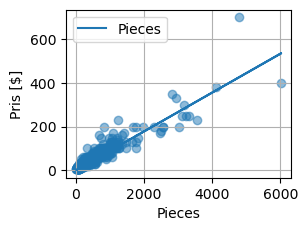

None

## Pages

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     1235.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          1.73e-153
Time:                        19:41:13   Log-Likelihood:                -3252.3
No. Observations:                 664   AIC:                             6509.
Df Residuals:                     662   BIC:                             6518.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.3538      2.020     -4.136      0.000     -12.320      -4.388
Pages          0.5065      0.014     35.144      0.000       0.478       0.535
==============================================================================
Omnibus:                      791.181   Durbin-Watson:                   1.403
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           164891.516
Skew:                           5.446   Prob(JB):                         0.00
Kurtosis:                      79.428   Cond. No.                         225.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

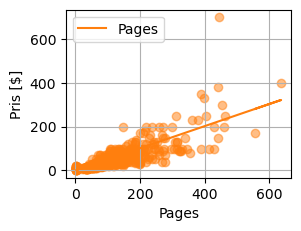

None

## Minifigures

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     342.1
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           6.82e-62
Time:                        19:41:13   Log-Likelihood:                -3463.5
No. Observations:                 664   AIC:                             6931.
Df Residuals:                     662   BIC:                             6940.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.5823      2.836      1.968      0.049       0.013      11.151
Minifigures    12.7738      0.691     18.497      0.000      11.418      14.130
==============================================================================
Omnibus:                      846.916   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183689.189
Skew:                           6.193   Prob(JB):                         0.00
Kurtosis:                      83.535   Cond. No.                         6.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

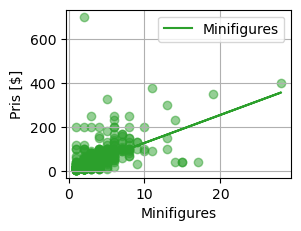

None

## Unique_Pieces

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1519.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          1.42e-173
Time:                        19:41:13   Log-Likelihood:                -3205.9
No. Observations:                 664   AIC:                             6416.
Df Residuals:                     662   BIC:                             6425.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -13.9146      1.958     -7.107      0.000     -17.759     -10.070
Unique_Pieces     0.4015      0.010     38.980      0.000       0.381       0.422
==============================================================================
Omnibus:                     1060.430   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           629773.876
Skew:                           9.191   Prob(JB):                         0.00
Kurtosis:                     152.750   Cond. No.                         317.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

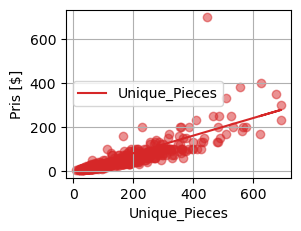

None

In [9]:
from IPython.display import display, Markdown

# multippel lineær regresjon
fields = ['Pieces', 'Pages', 'Minifigures', 'Unique_Pieces']

subplot_cols = subplot_rows = math.ceil(math.sqrt(len(fields)))

for i, field in enumerate(fields):
    model4b3 = smf.ols('Price ~ ' + field, data = df2)
    fit      = model4b3.fit()
    display(Markdown(f"## {field}"))
    display(fit.summary())
    
    slope    = fit.params[field]
    regression_x = np.array(df2[field])
    regression_y = slope * regression_x

    plt.subplot(subplot_cols, subplot_rows, i+1)
    plt.scatter(df2[field], df2['Price'], color=plt.cm.tab10(i), alpha=0.5)
    plt.plot(df2[field], regression_y, color=plt.cm.tab10(i), label=field)
        
    plt.xlabel(field)
    plt.ylabel('Pris [$]')
    plt.legend()
    plt.grid()
    display(plt.show())
    

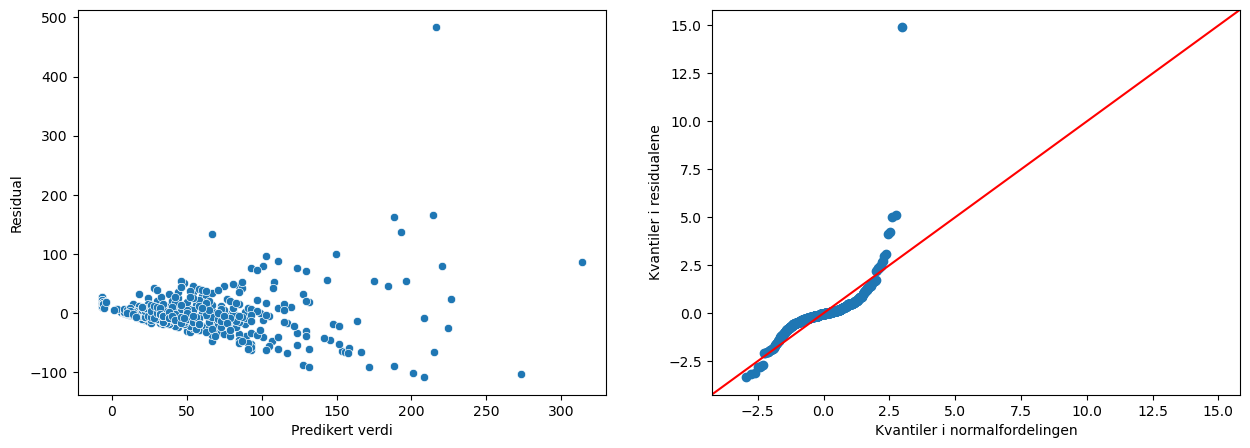

In [10]:
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = result.fittedvalues, y = result.resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

sm.qqplot(result.resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()

## 4.C.A) Pris beskrevet av antall brikker, per gruppe (3x LR)

### trademarked

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1740.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          1.05e-118
Time:                        19:41:13   Log-Likelihood:                -1220.4
No. Observations:                 268   AIC:                             2445.
Df Residuals:                     266   BIC:                             2452.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7661      1.737      4.470      0.000       4.346      11.186
Pieces         0.0946      0.002     41.712      0.000       0.090       0.099
==============================================================================
Omnibus:                      227.067   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35232.654
Skew:                           2.490   Prob(JB):                         0.00
Kurtosis:                      58.950   Cond. No.                         944.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### uncertain

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     838.9
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           1.06e-40
Time:                        19:41:13   Log-Likelihood:                -316.81
No. Observations:                  72   AIC:                             637.6
Df Residuals:                      70   BIC:                             642.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6749      2.898      2.648      0.010       1.895      13.455
Pieces         0.0817      0.003     28.963      0.000       0.076       0.087
==============================================================================
Omnibus:                       86.811   Durbin-Watson:                   2.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1369.690
Skew:                           3.473   Prob(JB):                    3.76e-298
Kurtosis:                      23.207   Cond. No.                     1.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### no trademark

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     1595.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          8.90e-127
Time:                        19:41:13   Log-Likelihood:                -1376.8
No. Observations:                 324   AIC:                             2758.
Df Residuals:                     322   BIC:                             2765.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4474      1.273      6.635      0.000       5.943      10.952
Pieces         0.0860      0.002     39.938      0.000       0.082       0.090
==============================================================================
Omnibus:                      182.673   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2790.215
Skew:                           1.969   Prob(JB):                         0.00
Kurtosis:                      16.827   Cond. No.                         797.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

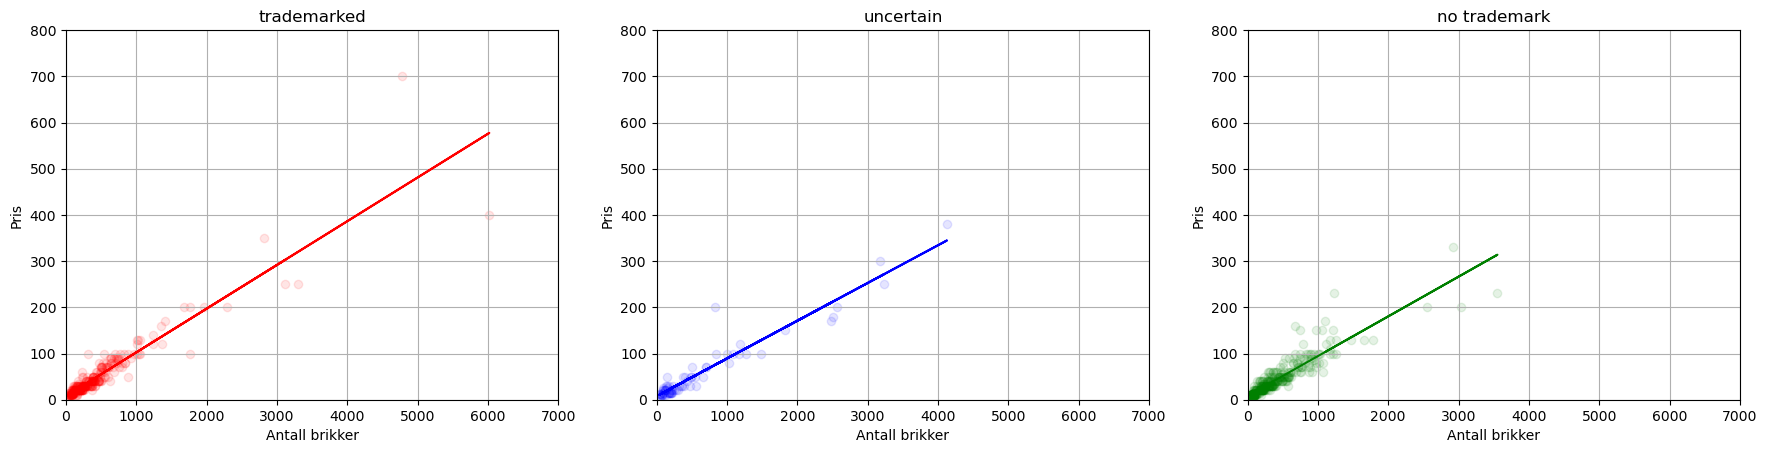

In [11]:

subsets = [
    {
        "data": df_trademark, 
        "name": "trademarked",
        "color" : "red"
    },
    {
        "data": df_uncertain,
        "name": "uncertain",
        "color": "blue"
    },
    {
        "data": df_notrademark,
        "name": "no trademark",
        "color": "green"
    }
]

plots=[]

for i,subset in enumerate(subsets):
    data = subset['data']
    model = smf.ols('Price ~ Pieces' , data = data)
    fit = model.fit()
    display(Markdown(f'### {subset["name"]}'))
    display(fit.summary())
    
    slope = fit.params['Pieces']
    intercept = fit.params['Intercept']

    reg_x = np.array(data['Pieces'])
    reg_y = slope * reg_x + intercept

    # Plot scatter plot and regression line
    plt.subplot(1, len(subsets), i+1)
    plt.ylim([0, 800])
    plt.xlim([0, 7000])
    plt.grid()
    plt.title(subset['name'])
    plt.xlabel('Antall brikker')
    plt.ylabel('Pris')
    fig = plt.gcf()
    current_width, current_height = plt.gcf().get_size_inches()
    fig.set_figwidth(current_width * 1.5)
    plt.scatter(data['Pieces'], data['Price'], color=subset['color'], alpha=0.1)
    plt.plot(reg_x, reg_y, color=subset['color'], label=subset['name'])


plt.show()

## MLR

In [12]:
df2['Category'] = np.where(
    df2['Theme'].isin(
        trademarked
    ),
    'trademark',
    np.where(
        df2['Theme'].isin(
            notrademark
        ),
        'no trademark',
        np.where(
            df2['Theme'].isin(
                uncertain   
            ),
            'uncertain',
            'unaccounted for'
        )
    )
)
df2.groupby(['Category']).size().reset_index(name = 'Count')

# multippel lineær regresjon
modell3_mlr = smf.ols('Price ~ Pieces + Category' , data = df2)
modell3_mlr.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1415.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          6.50e-287
Time:                        19:41:13   Log-Likelihood:                -2935.9
No. Observations:                 664   AIC:                             5880.
Df Residuals:                     660   BIC:                             5898.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.1956      1.247      5.768      0.000       4.746       9.645
Category[T.trademark]     3.0399      1.669      1.821      0.069      -0.238       6.318
Category[T.uncertain]    -3.9667      2.646     -1.499      0.134      -9.163       1.229
Pieces                    0.0891      0.001     64.860      0.000       0.086       0.092
==============================================================================
Omnibus:                      619.596   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79208.710
Skew:                           3.630   Prob(JB):                         0.00
Kurtosis:                      56.012   Cond. No.                     2.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## MLR med eget stigningstall for hver kategori

# Pages

### MLR Summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     426.1
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          1.44e-203
Time:                        19:41:57   Log-Likelihood:                -3122.4
No. Observations:                 664   AIC:                             6257.
Df Residuals:                     658   BIC:                             6284.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.1804      2.356     -0.501      0.617      -5.806       3.446
Category[T.trademark]         -22.6878      3.619     -6.269      0.000     -29.794     -15.582
Category[T.uncertain]         -22.0075      5.567     -3.953      0.000     -32.939     -11.076
Pages                           0.3681      0.015     23.936      0.000       0.338       0.398
Pages:Category[T.trademark]     0.3844      0.027     14.132      0.000       0.331       0.438
Pages:Category[T.uncertain]     0.3598      0.039      9.211      0.000       0.283       0.437
==============================================================================
Omnibus:                      783.865   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           146281.365
Skew:                           5.398   Prob(JB):                         0.00
Kurtosis:                      74.908   Cond. No.                         838.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Kryssplot

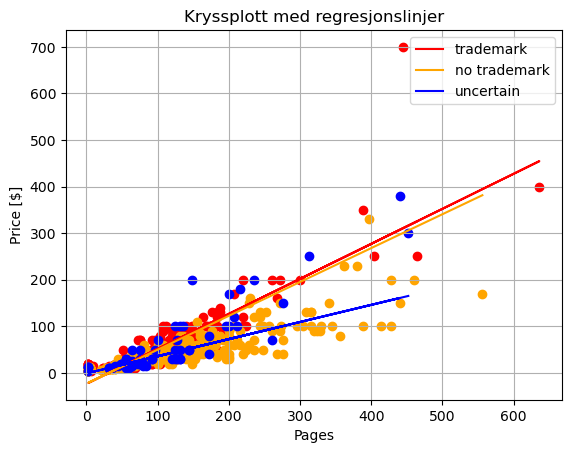

### QQ og residualplot

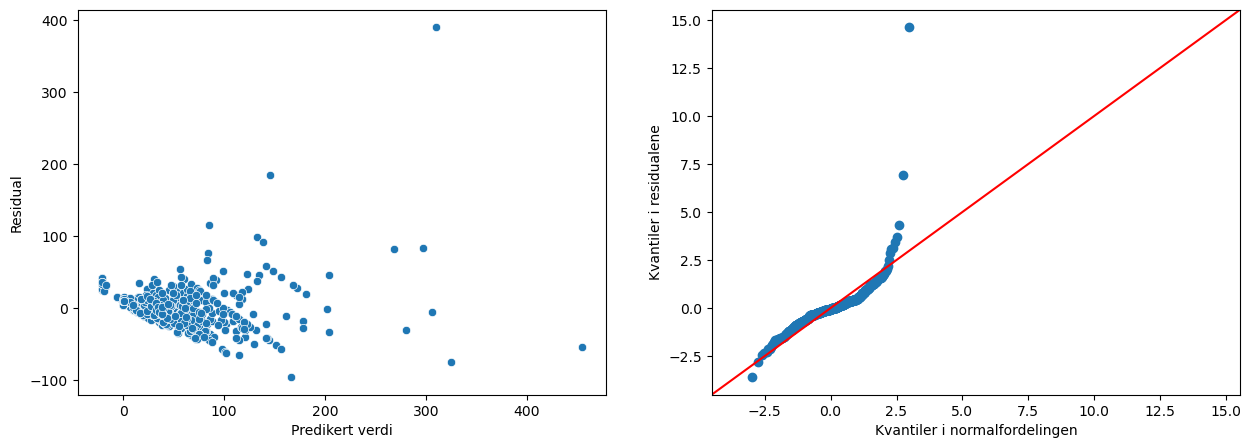

# Pieces

### MLR Summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     870.8
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          2.82e-287
Time:                        19:41:57   Log-Likelihood:                -2927.7
No. Observations:                 664   AIC:                             5867.
Df Residuals:                     658   BIC:                             5894.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        8.4474      1.496      5.647      0.000       5.510      11.385
Category[T.trademark]           -0.6813      2.122     -0.321      0.748      -4.847       3.485
Category[T.uncertain]           -0.7725      3.260     -0.237      0.813      -7.174       5.629
Pieces                           0.0860      0.003     33.993      0.000       0.081       0.091
Pieces:Category[T.trademark]     0.0087      0.003      2.709      0.007       0.002       0.015
Pieces:Category[T.uncertain]    -0.0043      0.004     -1.129      0.259      -0.012       0.003
==============================================================================
Omnibus:                      499.463   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59728.259
Skew:                           2.512   Prob(JB):                         0.00
Kurtosis:                      49.191   Cond. No.                     3.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Kryssplot

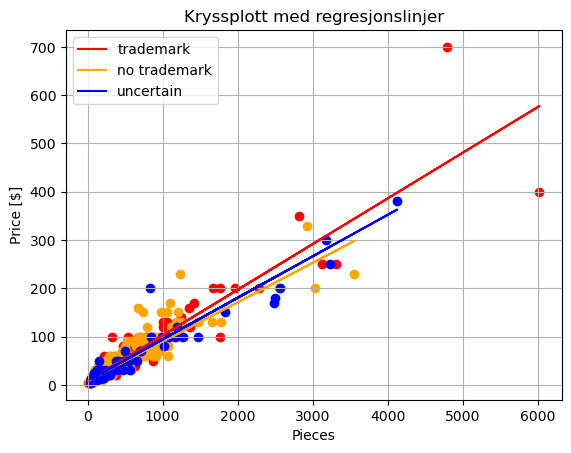

### QQ og residualplot

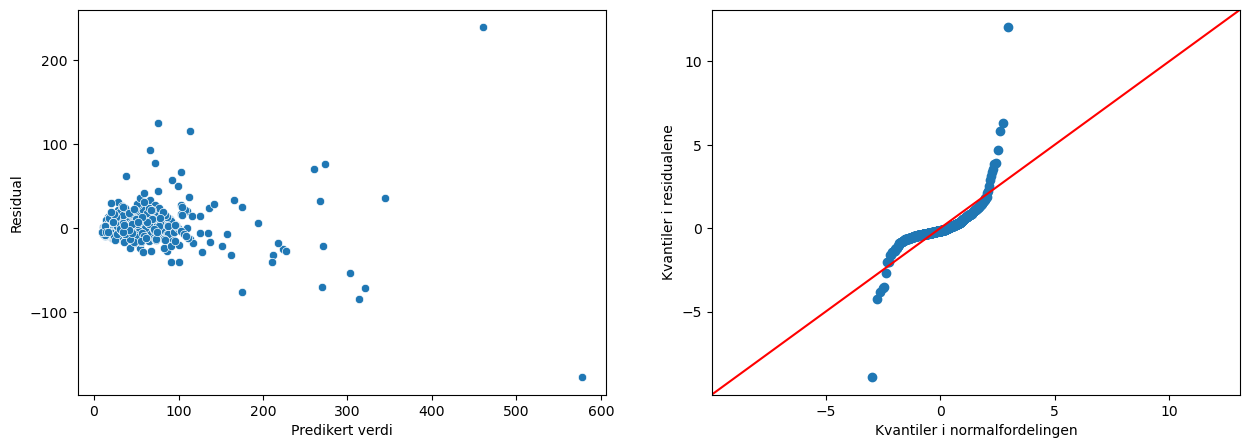

# Unique_Pieces

### MLR Summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     389.8
Date:                Fri, 17 Nov 2023   Prob (F-statistic):          5.50e-194
Time:                        19:41:57   Log-Likelihood:                -3144.7
No. Observations:                 664   AIC:                             6301.
Df Residuals:                     658   BIC:                             6328.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -6.4779      2.548     -2.542      0.011     -11.481      -1.474
Category[T.trademark]                 -19.5259      3.930     -4.968      0.000     -27.243     -11.809
Category[T.uncertain]                 -11.8393      5.600     -2.114      0.035     -22.835      -0.844
Unique_Pieces                           0.3153      0.013     24.133      0.000       0.290       0.341
Unique_Pieces:Category[T.trademark]     0.2138      0.022      9.917      0.000       0.171       0.256
Unique_Pieces:Category[T.uncertain]     0.1337      0.026      5.122      0.000       0.082       0.185
==============================================================================
Omnibus:                     1070.955   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           661670.762
Skew:                           9.367   Prob(JB):                         0.00
Kurtosis:                     156.508   Cond. No.                     1.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Kryssplot

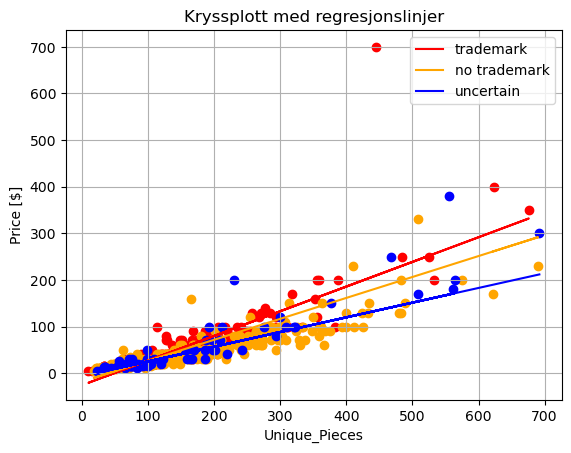

### QQ og residualplot

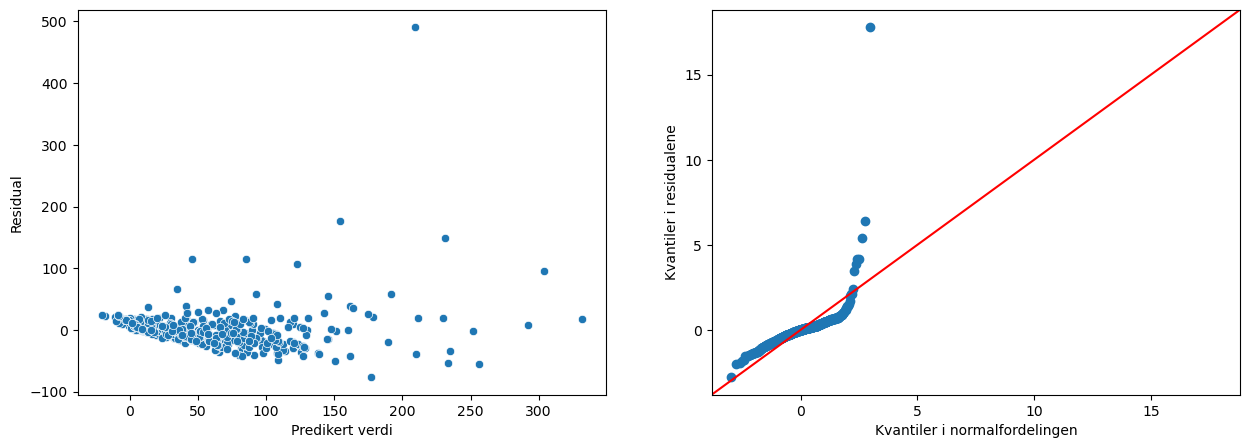

# Minifigures

### MLR Summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     70.91
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           2.43e-59
Time:                        19:41:58   Log-Likelihood:                -3458.7
No. Observations:                 664   AIC:                             6929.
Df Residuals:                     658   BIC:                             6956.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             8.3379      3.947      2.113      0.035       0.588      16.087
Category[T.trademark]                -5.8775      6.107     -0.962      0.336     -17.869       6.114
Category[T.uncertain]                -2.8067      9.119     -0.308      0.758     -20.712      15.099
Minifigures                          10.9795      0.988     11.108      0.000       9.039      12.920
Minifigures:Category[T.trademark]     3.1677      1.497      2.116      0.035       0.229       6.107
Minifigures:Category[T.uncertain]     3.8911      2.094      1.858      0.064      -0.222       8.004
==============================================================================
Omnibus:                      851.864   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           194280.746
Skew:                           6.241   Prob(JB):                         0.00
Kurtosis:                      85.864   Cond. No.                         26.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Kryssplot

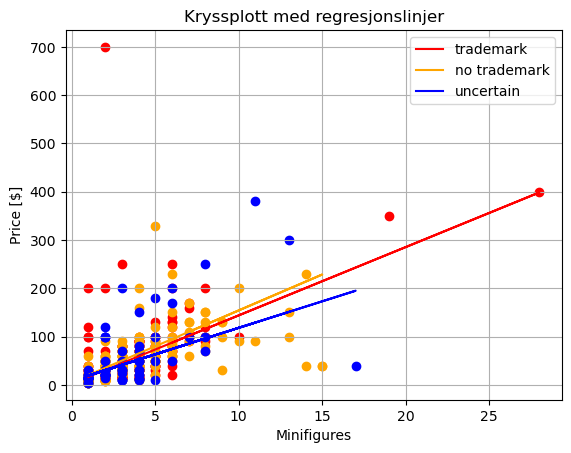

### QQ og residualplot

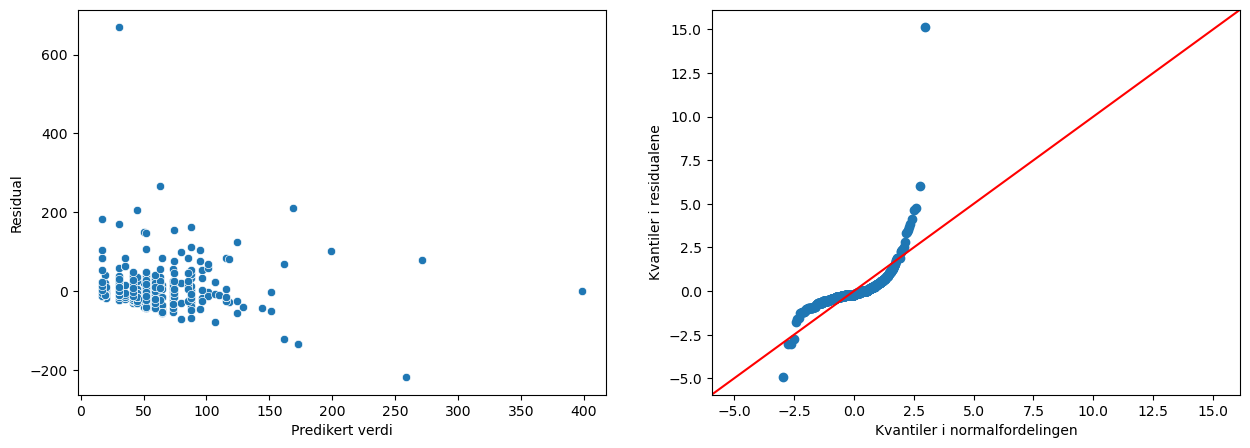

### Sorted by price_per_Pages

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages,Category,price_per_Pages,price_per_Pieces,price_per_Unique_Pieces,price_per_Minifigures
412,Outback Adventures,Creator 3-in-1,225.0,19.99,148.0,1.0,103.0,Ages_7-12,no trademark,0.135068,0.088844,0.194078,19.990000
436,Space Rover Explorer,Creator 3-in-1,510.0,39.99,276.0,1.0,206.0,Ages_8+,no trademark,0.144891,0.078412,0.194126,39.990000
53,Spider-Man Mech,Marvel,152.0,9.99,68.0,1.0,62.0,Ages_6+,trademark,0.146912,0.065724,0.161129,9.990000
435,Townhouse Toy Store,Creator 3-in-1,554.0,39.99,268.0,2.0,194.0,Ages_8+,no trademark,0.149216,0.072184,0.206134,19.995000
314,Race Plane,Creator 3-in-1,333.0,29.99,200.0,1.0,134.0,Ages_7+,no trademark,0.149950,0.090060,0.223806,29.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,Spider-Man and the Museum Break-In,Marvel,49.0,14.99,3.0,3.0,33.0,Ages_8+,trademark,4.996667,0.305918,0.454242,4.996667
130,Anna and Elsa's Storybook Adventures,LEGO Frozen 2,133.0,19.99,3.0,4.0,71.0,Ages_5+,trademark,6.663333,0.150301,0.281549,4.997500
132,Belle's Storybook Adventures,Disney,111.0,19.99,3.0,5.0,71.0,Ages_5+,trademark,6.663333,0.180090,0.281549,3.998000
108,Mulan's Storybook Adventures,Disney,124.0,19.99,3.0,3.0,72.0,Ages_5+,trademark,6.663333,0.161210,0.277639,6.663333


### Sorted by price_per_Pieces

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages,Category,price_per_Pages,price_per_Pieces,price_per_Unique_Pieces,price_per_Minifigures
550,Ocean's Bottom,Classic,579.0,29.99,57.0,2.0,218.0,Ages_5-99,no trademark,0.526140,0.051796,0.137569,14.995000
335,Formula E Panasonic Jaguar Racing GEN2 Car & J...,Speed Champions,565.0,29.99,128.0,2.0,186.0,Ages_8+,uncertain,0.234297,0.053080,0.161237,14.995000
1074,Diagon Alley,Harry Potter,374.0,19.99,72.0,1.0,116.0,Ages_10+,trademark,0.277639,0.053449,0.172328,19.990000
1043,Fun Future,Classic,186.0,9.99,49.0,1.0,95.0,Ages_5-99,no trademark,0.203878,0.053710,0.105158,9.990000
586,Central Perk,Ideas,1070.0,59.99,156.0,7.0,366.0,Ages_16+,no trademark,0.384551,0.056065,0.163907,8.570000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,Police MF Accessory Set,Minifigures,42.0,12.99,3.0,4.0,33.0,Ages_6+,uncertain,4.330000,0.309286,0.393636,3.247500
757,App-Controlled Batmobile,DC,321.0,99.99,108.0,1.0,114.0,Ages_8+,trademark,0.925833,0.311495,0.877105,99.990000
263,Fire Helicopter Response,City,93.0,29.99,44.0,3.0,61.0,Ages_5+,no trademark,0.681591,0.322473,0.491639,9.996667
976,Obi-Wan Kenobi - Collectable Minifigure,Star Wars,12.0,3.99,6.0,1.0,10.0,Ages_6+,trademark,0.665000,0.332500,0.399000,3.990000


### Sorted by price_per_Unique_Pieces

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages,Category,price_per_Pages,price_per_Pieces,price_per_Unique_Pieces,price_per_Minifigures
1043,Fun Future,Classic,186.0,9.99,49.0,1.0,95.0,Ages_5-99,no trademark,0.203878,0.053710,0.105158,9.990000
848,Police Water Plane,City,48.0,3.99,3.0,1.0,36.0,Ages_5-12,no trademark,1.330000,0.083125,0.110833,3.990000
849,Arctic Ice Saw,City,43.0,3.99,3.0,1.0,34.0,Ages_5-12,no trademark,1.330000,0.092791,0.117353,3.990000
42,Unikitty Cloud Car,Unikitty,126.0,9.99,60.0,3.0,83.0,Ages_5-12,uncertain,0.166500,0.079286,0.120361,3.330000
846,Road Worker,City,58.0,3.99,3.0,1.0,33.0,Ages_5-12,no trademark,1.330000,0.068793,0.120909,3.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,Garage Centre,City,234.0,49.99,116.0,4.0,62.0,Ages_4+,no trademark,0.430948,0.213632,0.806290,12.497500
787,Vestas Wind Turbine,Creator Expert,826.0,199.99,148.0,3.0,230.0,Ages_12+,uncertain,1.351284,0.242119,0.869522,66.663333
757,App-Controlled Batmobile,DC,321.0,99.99,108.0,1.0,114.0,Ages_8+,trademark,0.925833,0.311495,0.877105,99.990000
752,Passenger Train,City,677.0,159.99,230.0,4.0,165.0,Ages_6-12,no trademark,0.695609,0.236322,0.969636,39.997500


### Sorted by price_per_Minifigures

,Set_Name,Theme,Pieces,Price,Pages,Minifigures,Unique_Pieces,Ages,Category,price_per_Pages,price_per_Pieces,price_per_Unique_Pieces,price_per_Minifigures
200,Benny's Space Squad,THE LEGO MOVIE 2,68.0,9.99,32.0,5.0,53.0,Ages_5+,uncertain,0.312188,0.146912,0.188491,1.998000
610,Unikingdom Creative Brick Box,Unikitty,433.0,39.99,172.0,17.0,220.0,Ages_5-12,uncertain,0.232500,0.092356,0.181773,2.352353
152,Good Morning Sparkle Babies!,THE LEGO MOVIE 2,50.0,9.99,32.0,4.0,44.0,Ages_6+,uncertain,0.312188,0.199800,0.227045,2.497500
243,Mining Team,City,82.0,9.99,32.0,4.0,64.0,Ages_5-12,no trademark,0.312188,0.121829,0.156094,2.497500
134,Mountain Fugitives,City,88.0,9.99,36.0,4.0,61.0,Ages_5-12,no trademark,0.277500,0.113523,0.163770,2.497500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,App-Controlled Batmobile,DC,321.0,99.99,108.0,1.0,114.0,Ages_8+,trademark,0.925833,0.311495,0.877105,99.990000
1160,Y-wing Starfighter,Star Wars,1967.0,199.99,220.0,2.0,359.0,Ages_14+,trademark,0.909045,0.101673,0.557075,99.995000
788,The Hulkbuster: Ultron Edition,Marvel,1363.0,119.99,184.0,1.0,268.0,Ages_14+,trademark,0.652120,0.088034,0.447724,119.990000
797,A-wing Starfighter,Star Wars,1673.0,199.99,272.0,1.0,355.0,Ages_18+,trademark,0.735257,0.119540,0.563352,199.990000


In [14]:
df2['Category'] = np.where(
    df2['Theme'].isin(
        trademarked
    ),
    'trademark',
    np.where(
        df2['Theme'].isin(
            notrademark
        ),
        'no trademark',
        np.where(
            df2['Theme'].isin(
                uncertain   
            ),
            'uncertain',
            'unaccounted for'
        )
    )
)
df2.groupby(['Category']).size().reset_index(name = 'Count')

#df2 = df2[df2['Price'] <= 400]

#plt.figure(figsize=(12, 8))
#sns.boxplot(x='Category', y='Price', data=df2)
#plt.title('Box Plot of Prices by Theme Category')
#plt.xlabel('Theme Category')
#plt.ylabel('Price')
#display(plt.show())

for field in ["Pages", "Pieces", "Unique_Pieces", "Minifigures"]:
    display(Markdown(f'# {field}'))
    
    #fields = ['Pieces', 'Pages', 'Minifigures', 'Unique_Pieces']
    model = smf.ols(f'Price ~ {field} * Category' , data = df2)
    fit = model.fit()
    
    display(Markdown('### MLR Summary'))
    display(fit.summary())
        
    # Regresjonslinjer
    intercept = [fit.params['Category[T.trademark]'],          fit.params['Category[T.uncertain]'], 0]          + fit.params['Intercept']
    slope     = [fit.params[f'{field}:Category[T.trademark]'], fit.params[f'{field}:Category[T.uncertain]'], 0] + fit.params[field]
    
    colors = [
        {'c': 'red',    'a': 1},
        {'c': 'orange', 'a': 1},
        {'c': 'blue',   'a': 1}
    ]
    
    for i, theme in enumerate(['trademark', 'no trademark', 'uncertain']):
        subset = df2[df2['Category'].isin([theme])]
        
        regression_x = np.array(subset[field])
        regression_y = slope[i] * regression_x + intercept[i]
    
        # Plot scatter plot and regression line
        plt.scatter(subset[field], subset['Price'], color=colors[i]['c'], alpha=colors[i]['a'])
        plt.plot(regression_x, regression_y, color=colors[i]['c'], alpha=colors[i]['a'], label=theme)
    
        
    plt.xlabel(field)
    plt.ylabel('Price [$]')
    plt.title('Kryssplott med regresjonslinjer')
    plt.legend()
    plt.grid()
    
    # Display
    display(Markdown('### Kryssplot'))
    plt.show()
    
    # QQ og residualplot
    figure, axis = plt.subplots(1, 2, figsize = (15, 5))
    sns.scatterplot(x = fit.fittedvalues, y = fit.resid, ax = axis[0])
    axis[0].set_ylabel("Residual")
    axis[0].set_xlabel("Predikert verdi")
        
    sm.qqplot(fit.resid, line = '45', fit = True, ax = axis[1])
    axis[1].set_ylabel("Kvantiler i residualene")
    axis[1].set_xlabel("Kvantiler i normalfordelingen")
    
   
    display(Markdown('### QQ og residualplot'))
    plt.show()
    df2[f'price_per_{field}'] = df2['Price'] / df2[field]


for field in ["Pages", "Pieces", "Unique_Pieces", "Minifigures"]:
    display(Markdown(f'### Sorted by price_per_{field}'))
    display(df2.sort_values(by=[f'price_per_{field}']))

